In [1]:
import pandas as pd
import numpy as np

# 1. Set seed for reproducibility
np.random.seed(42)

# 2. Define the number of students as 1000
n_new = 1000

# 3. Generate unique student IDs for 1000 students in the format 'A000100234'
student_ids = [f'A{i:09d}' for i in range(n_new)]

# 4. Generate synthetic data for features
new_data = {
    'student_id': student_ids,
    'currentGPA': np.clip(np.round(np.random.beta(3.5, 1.5, n_new) * 4, 2) + np.random.normal(0, 0.2, n_new), 0, 4),
    'outstandingBalance': np.round(np.random.gamma(1.5, 800, n_new), 2),
    'loginsThisSemester': np.random.poisson(25, n_new).clip(0, 60),
    'classesMissed': np.random.poisson(4, n_new).clip(0, 25),
    'incidentCount': np.random.poisson(0.4, n_new).clip(0, 6),
    'sessionsAttended': np.random.poisson(3, n_new).clip(0, 10),
}

df_new = pd.DataFrame(new_data)

# 7. Add correlations (e.g., low GPA correlates with more missed classes)
df_new.loc[df_new['currentGPA'] < 2.2, 'classesMissed'] += np.random.randint(4, 12, sum(df_new['currentGPA'] < 2.2))

# 8. Introduce NaN values for 'loginsThisSemester' and 'sessionsAttended'
# Randomly select 20% of rows for each column and set to NaN
nan_percentage = 0.2

logins_nan_indices = np.random.choice(df_new.index, size=int(n_new * nan_percentage), replace=False)
df_new.loc[logins_nan_indices, 'loginsThisSemester'] = np.nan

sessions_nan_indices = np.random.choice(df_new.index, size=int(n_new * nan_percentage), replace=False)
df_new.loc[sessions_nan_indices, 'sessionsAttended'] = np.nan

# 9. Create the 'at_risk' binary label emphasizing 'currentGPA' and 'outstandingBalance'
df_new['at_risk'] = (
    (df_new['currentGPA'] < 2.0) & (df_new['outstandingBalance'] > 1500) |
    (df_new['currentGPA'] < 2.5) & (df_new['outstandingBalance'] > 1000) |
    (df_new['loginsThisSemester'].notna() & (df_new['loginsThisSemester'] < 8) & (df_new['classesMissed'] > 12)) |
    (df_new['incidentCount'] > 5) |
    (df_new['sessionsAttended'].notna() & (df_new['sessionsAttended'] < 1))
).astype(int)

# 10. Add 1% noise to target for realism
flip_new = np.random.choice(df_new.index, size=int(0.01 * n_new), replace=False)
df_new.loc[flip_new, 'at_risk'] = 1 - df_new.loc[flip_new, 'at_risk']

# 11. Save the DataFrame to a CSV file
output_filename = 'new_synthetic_aun_students.csv'
df_new.to_csv(output_filename, index=False)
print(f"New synthetic data saved to '{output_filename}'.")

# 12. Print the value counts of the 'at_risk' column
print("\nRisk distribution in new data:")
print(df_new['at_risk'].value_counts())

New synthetic data saved to 'new_synthetic_aun_students.csv'.

Risk distribution in new data:
at_risk
0    817
1    183
Name: count, dtype: int64


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Load the 'new_synthetic_aun_students.csv' file into a pandas DataFrame.
df_processed = pd.read_csv('new_synthetic_aun_students.csv')

# 2. For 'loginsThisSemester' and 'sessionsAttended' columns, create new binary indicator columns
#    named 'loginsThisSemester_is_na' and 'sessionsAttended_is_na' respectively.
df_processed['loginsThisSemester_is_na'] = df_processed['loginsThisSemester'].isna().astype(int)
df_processed['sessionsAttended_is_na'] = df_processed['sessionsAttended'].isna().astype(int)

# 3. Impute any remaining NaN values in 'loginsThisSemester' and 'sessionsAttended' columns with the sentinel value 0.
df_processed['loginsThisSemester'] = df_processed['loginsThisSemester'].fillna(0)
df_processed['sessionsAttended'] = df_processed['sessionsAttended'].fillna(0)

print("NaN values after imputation and indicator creation:")
print(df_processed[['loginsThisSemester', 'sessionsAttended', 'loginsThisSemester_is_na', 'sessionsAttended_is_na']].isnull().sum())

# 4. Define the feature columns to include original features, imputed features, and new indicator columns.
features_new = [
    'currentGPA', 'outstandingBalance', 'loginsThisSemester',
    'classesMissed', 'incidentCount', 'sessionsAttended',
    'loginsThisSemester_is_na', 'sessionsAttended_is_na'
]

# 5. Split df_processed into features (X_new) and target (y_new), where y_new is the 'at_risk' column.
X_new = df_processed[features_new]
y_new = df_processed['at_risk']

# 6. Split X_new and y_new into training and testing sets (X_train_new, X_test_new, y_train_new, y_test_new)
#    using an 80/20 split, random_state=42, and stratify=y_new for balanced classes.
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=42, stratify=y_new)

print(f"\nShape of X_train_new: {X_train_new.shape}")
print(f"Shape of X_test_new: {X_test_new.shape}")
print(f"Shape of y_train_new: {y_train_new.shape}")
print(f"Shape of y_test_new: {y_test_new.shape}")
print("Data loaded, preprocessed, and split into training and testing sets.")

NaN values after imputation and indicator creation:
loginsThisSemester          0
sessionsAttended            0
loginsThisSemester_is_na    0
sessionsAttended_is_na      0
dtype: int64

Shape of X_train_new: (800, 8)
Shape of X_test_new: (200, 8)
Shape of y_train_new: (800,)
Shape of y_test_new: (200,)
Data loaded, preprocessed, and split into training and testing sets.


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd

# 1. Initialize models
models_comparison = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'XGBoost': XGBClassifier(random_state=42, max_depth=6, learning_rate=0.1, n_estimators=100, subsample=0.8, colsample_bytree=0.8),
}

# 2. Define a parameter grid for the Random Forest Classifier for tuning
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 3. Instantiate GridSearchCV for Random Forest
# Using GridSearchCV as it was mentioned as an option and provides exhaustive search
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1 # Use all available cores
)

print("Performing GridSearchCV for Random Forest...")
# 4. Fit GridSearchCV to the training data
grid_search_rf.fit(X_train_new, y_train_new)

# 5. Store the best Random Forest model
best_rf_model = grid_search_rf.best_estimator_
print(f"Best Random Forest parameters: {grid_search_rf.best_params_}")
print(f"Best Random Forest AUC score (CV): {grid_search_rf.best_score_:.3f}")

# Add the best tuned Random Forest model to the comparison models
models_comparison['Tuned Random Forest'] = best_rf_model

model_results_tuned = {}

print("\nModel Comparison on Test Data:")
# 6 & 7. Train other models (if not already fit by GridSearchCV) and 8. Evaluate all models
for name, model in models_comparison.items():
    if name not in ['Tuned Random Forest']: # Tuned RF is already fit
        model.fit(X_train_new, y_train_new)

    probs_new = model.predict_proba(X_test_new)[:, 1]
    preds_new = model.predict(X_test_new)
    auc_new = roc_auc_score(y_test_new, probs_new)
    print(f"\n{name}")
    print(f"AUC: {auc_new:.3f}")
    print(classification_report(y_test_new, preds_new))
    model_results_tuned[name] = {'model': model, 'auc': auc_new, 'preds': preds_new, 'probs': probs_new}

# Explicitly set the best tuned Random Forest as the 'best_model_new' for downstream tasks
best_name_new = 'Tuned Random Forest'
best_model_new = model_results_tuned[best_name_new]['model']
best_auc_new = model_results_tuned[best_name_new]['auc']
rf_preds_new = model_results_tuned[best_name_new]['preds'] # Store RF predictions for confusion matrix
rf_probs_new = model_results_tuned[best_name_new]['probs'] # Store RF probabilities for risk scores

print(f"\nSelected Best Model (for downstream tasks): {best_name_new} (AUC on Test Set: {best_auc_new:.3f})")

Performing GridSearchCV for Random Forest...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Random Forest parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best Random Forest AUC score (CV): 0.992

Model Comparison on Test Data:

Logistic Regression
AUC: 0.832
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       163
           1       0.64      0.38      0.47        37

    accuracy                           0.84       200
   macro avg       0.75      0.66      0.69       200
weighted avg       0.83      0.84      0.83       200


XGBoost
AUC: 0.903
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       163
           1       1.00      0.86      0.93        37

    accuracy                           0.97       200
   macro avg       0.99      0.93      0.96       200
weighted avg       0.98      0.97      0.97       20

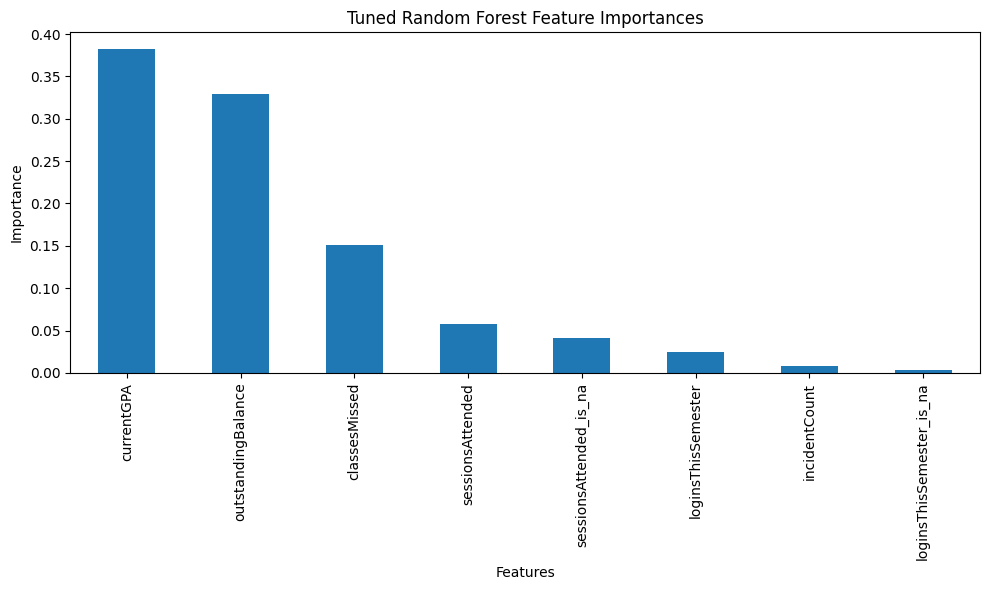

Feature importance plot for the tuned Random Forest model displayed.


In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a pandas.Series for feature importances using best_model_new.feature_importances_ and features_new as the index.
feature_importances_tuned = pd.Series(best_model_new.feature_importances_, index=X_new.columns) # Use X_new.columns as features_new is now global with indicator columns

# Create a bar plot of feature_importances_tuned sorted in descending order.
plt.figure(figsize=(10, 6))
feature_importances_tuned.sort_values(ascending=False).plot(kind='bar')

# Set the title of the plot to 'Tuned Random Forest Feature Importances (New Data)'.
plt.title('Tuned Random Forest Feature Importances')

# Label the y-axis 'Importance' and the x-axis 'Features'.
plt.ylabel('Importance')
plt.xlabel('Features')

# Use plt.tight_layout() to ensure all elements fit within the figure.
plt.tight_layout()

# Display the plot using plt.show().
plt.show()
print("Feature importance plot for the tuned Random Forest model displayed.")

<Figure size 800x600 with 0 Axes>

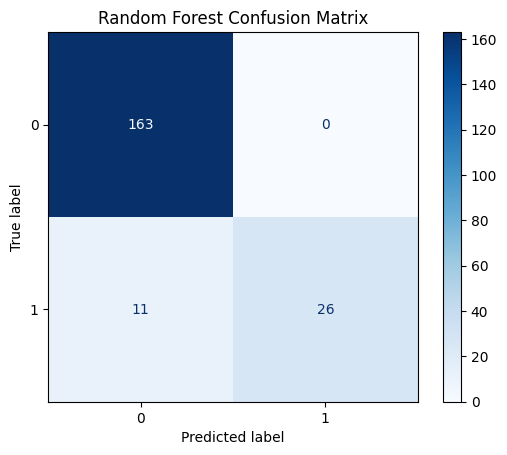

Confusion matrix plot for Random Forest model displayed.


In [5]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create a figure with a specified size.
plt.figure(figsize=(8, 6))

# Use ConfusionMatrixDisplay.from_predictions() to plot the confusion matrix.
# Pass y_test_new as the true labels and rf_preds_new (predictions from the best Random Forest model) as the predicted labels.
# Set the cmap to plt.cm.Blues.
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_new, rf_preds_new, cmap=plt.cm.Blues)

# Set the title of the confusion matrix plot to 'Random Forest Confusion Matrix'.
cm_display.ax_.set_title('Random Forest Confusion Matrix')

# Display the plot using plt.show().
plt.show()
print("Confusion matrix plot for Random Forest model displayed.")

In [7]:
import pandas as pd

# Generate scores for all students using the selected best_model_new (Tuned Random Forest)
df_processed['mlRiskScore'] = best_model_new.predict_proba(X_new)[:, 1].round(3)

# Save only student_id and mlRiskScore to a new CSV file
df_processed[['student_id', 'mlRiskScore']].to_csv('new_ml_risk_scores.csv', index=False)
print("New risk scores saved to 'new_ml_risk_scores.csv'!")
print(df_processed[['student_id', 'mlRiskScore', 'at_risk']].head(10))

New risk scores saved to 'new_ml_risk_scores.csv'!
   student_id  mlRiskScore  at_risk
0  A000000000        0.017        0
1  A000000001        0.093        0
2  A000000002        0.020        0
3  A000000003        0.139        0
4  A000000004        0.018        0
5  A000000005        0.153        0
6  A000000006        0.032        0
7  A000000007        0.037        0
8  A000000008        0.090        0
9  A000000009        0.025        0


In [8]:
import joblib

# 'best_model_new' is your retrained Random Forest model
joblib.dump(best_model_new, 'randomforest_best_model.pkl')
print("Retrained model saved as randomforest_best_model.pkl")

Retrained model saved as randomforest_best_model.pkl
